In [325]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [326]:
def f(x):
    return 3*x**2 - 4*x + 5

In [327]:
f(3.8)

33.120000000000005

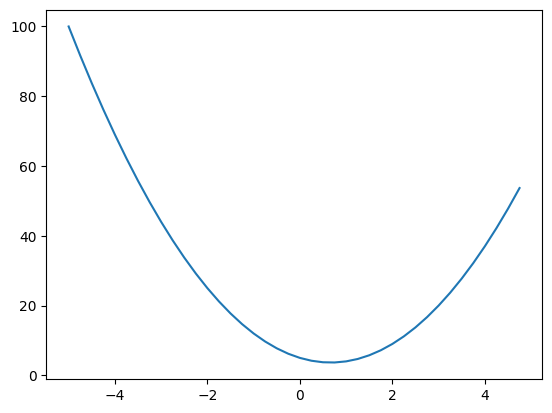

In [328]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [329]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __rmul__(self, other):
        return self*other
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other): 
        out = self * other.__pow__(-1)
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

In [330]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root): 
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)))

    return dot

In [331]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

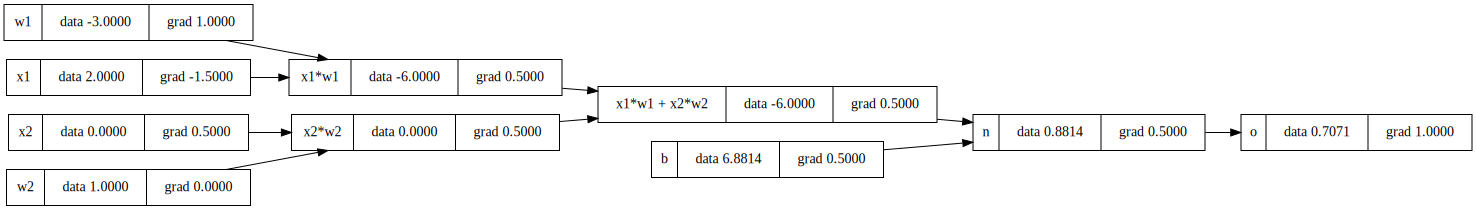

In [332]:
draw_dot(o)

In [333]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.label = 'o'
# ------
o.backward()

In [334]:
import torch
print(torch.cuda.is_available())

False


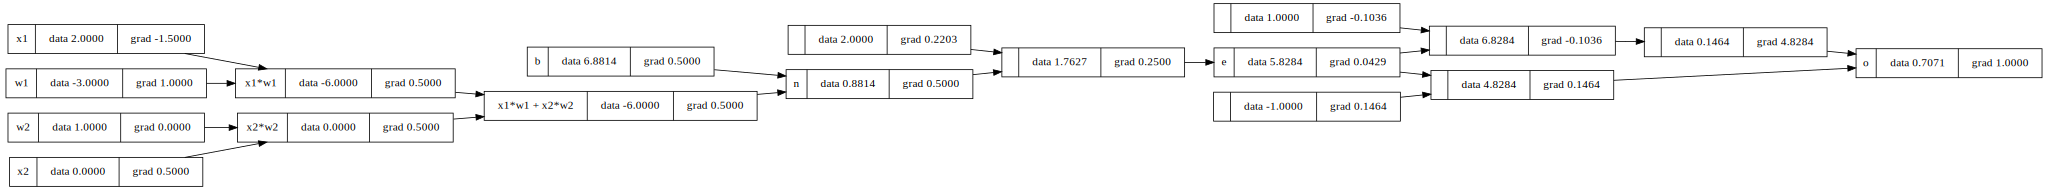

In [335]:
draw_dot(o)

In [336]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071050214706146
----
x1 -1.500007465833125
w1 1.0000049772220834
x2 0.5000024886110417
w2 0.0


In [378]:
class Neuron:
    def __init__(self, nin): 
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self): 
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]    

In [446]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7272401555210124)

In [447]:
len(n.parameters())

41

In [439]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [460]:
for k in range(10):
    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
    # Backward Pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.00022128937281142984
1 0.00022111963298441457
2 0.00022095015583485246
3 0.00022078094075074858
4 0.0002206119871220286
5 0.0002204432943404915
6 0.0002202748617998379
7 0.00022010668889565439
8 0.00021993877502539543
9 0.00021977111958838326


In [461]:
ypred

[Value(data=0.9946051046620348),
 Value(data=-0.9957859951593315),
 Value(data=-0.9929328483239975),
 Value(data=0.9889110976976085)]